<a href="https://colab.research.google.com/github/pranshudiwan/NLP_CS_6200/blob/main/NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sindhu Baseline LSTM

In [113]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wordcloud
!pip install pyspellchecker
from spellchecker import SpellChecker
import string
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Concatenate, LeakyReLU
from tqdm import tqdm

In [96]:

# Import train data
url_train = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/train.csv'
train = pd.read_csv(url_train)

# Import est data
url_test = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/test.csv'
test = pd.read_csv(url_test)

In [90]:
total_data = train.append(test)

## Visualization
- Class Distribution (number of tweets in each class)
- Number of characters in tweets
- Number of words in tweets
- Average length of word in a tweet

0    4342
1    3271
Name: target, dtype: int64 



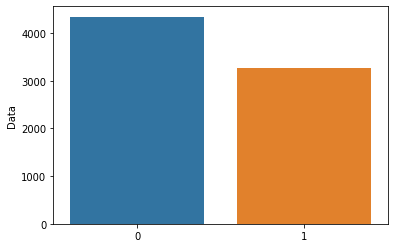

In [97]:
# Class distribution
class_counts=total_data.target.value_counts()
sns.barplot(x=class_counts.index,y=class_counts)
plt.gca().set_ylabel('Data')

print(class_counts , "\n")

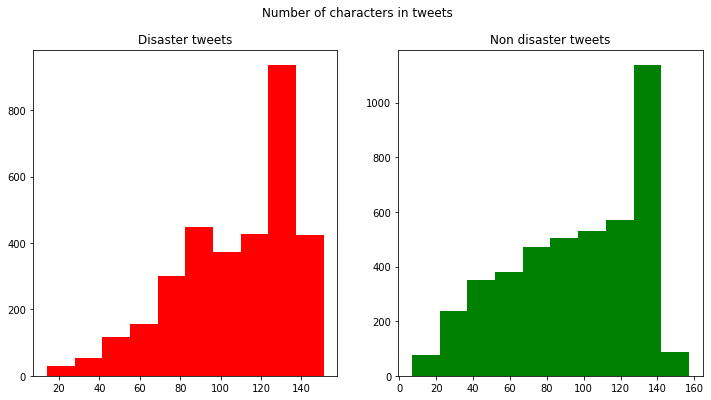

In [100]:
# Number of characters in tweets

# For Disaster tweets
disaster_tweet_len=train[train['target']==1]['text'].str.len()
#print(disaster_tweet_len)
non_disaster_tweet_len=train[train['target']==0]['text'].str.len()
#print(non_disaster_tweet_len)


# plotting
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
subplot1.hist(disaster_tweet_len,color='red')
subplot1.set_title('Disaster tweets')
subplot2.hist(non_disaster_tweet_len,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Number of characters in tweets')
plt.show()

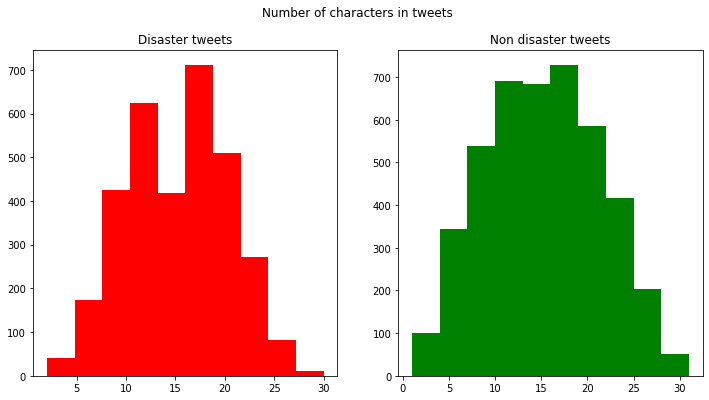

In [33]:
# Number of words in tweets

# For Disaster tweets
disaster_no_of_words=train[train['target']==1]['text'].str.split().map(lambda tweet : len(tweet))
#print(disaster_no_of_words)
non_disaster_no_of_words=train[train['target']==0]['text'].str.split().map(lambda tweet : len(tweet))
#print(non_disaster_no_of_words)


# Plotting number of words
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
subplot1.hist(disaster_no_of_words,color='red')
subplot1.set_title('Disaster tweets')
subplot2.hist(non_disaster_no_of_words,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Number of words in tweets')
plt.show()

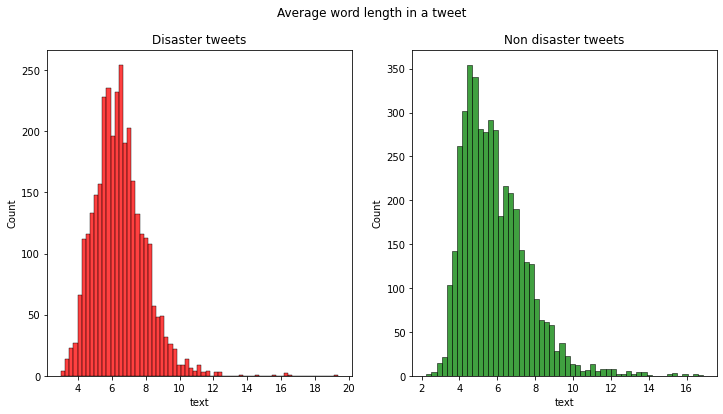

In [43]:
# Average length of word in a tweet

# For Disaster tweets
disaster_word_len=train[train['target']==1]['text'].str.split().apply(lambda tweet : [len(word) for word in tweet])
# print(disaster_word_len)
#print('Average word length of disaster tweets', disaster_word_len.map(lambda word_len: np.mean(word_len)))
non_disaster_word_len=train[train['target']==0]['text'].str.split().apply(lambda tweet : [len(word) for word in tweet])
# print(non_disaster_word_len)
#print('Average word length of non disaster tweets', non_disaster_word_len.map(lambda word_len: np.mean(word_len)))

# Plotting number of words
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
sns.histplot(disaster_word_len.map(lambda word_len: np.mean(word_len)),ax=subplot1,color='red')
subplot1.set_title('Disaster tweets')

sns.histplot(non_disaster_word_len.map(lambda word_len: np.mean(word_len)),ax=subplot2,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Average word length in a tweet')
plt.show()

## Data Cleaning for LSTM
- Remove punctuation
- Remove stopwords
- Remove non alphabets
- Remove emojis
- Spellcheck each word
- Expanding all slangs, acronyms and abbreviations

In [47]:
def remove_punctuation(data):
    return data.translate(str.maketrans('', '', string.punctuation))

In [50]:
def remove_stopwords(data):
    return ' '.join([word for word in data.split() if word not in wordcloud.STOPWORDS]) # using wordcloud stopwords instead of nltk stopwords

In [51]:
def remove_non_alphabet(data):
    return ' '.join([word for word in data.split() if word.isalpha()])

In [55]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

#train['text']=train['text'].apply(lambda x : correct_spellings(x))
#train.sample(5)

In [61]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [70]:
def expand_slang_abbr_acronyms(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [107]:
# CLEAN TRAIN DATA 

total_data = total_data.apply(lambda x: x.astype(str).str.lower())

total_data['text'] = total_data['text'].apply(remove_punctuation)
total_data['text'] = total_data['text'].apply(remove_stopwords)
total_data['text'] = total_data['text'].apply(remove_non_alphabet)
# total_data['text'] = total_data['text'].apply(correct_spellings)
total_data['text']=total_data['text'].apply(lambda x: remove_emoji(x))
## !Need to change variable names and abbrevations as appropriate
total_data["text"] = total_data["text"].apply(lambda x: expand_slang_abbr_acronyms(x))

#total_data.sample(10)

## Simple LSTM


In [105]:
tweets = [tweet for tweet in train['text']]

from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.preprocessing.text import Tokenizer

#define tokenizer options
tokenizer = Tokenizer()     
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 22700 unique tokens.
Shape of data tensor: (7613, 33)
Shape of label tensor: (7613,)


In [119]:
print(word_index)

{'t': 1, 'co': 2, 'http': 3, 'the': 4, 'a': 5, 'in': 6, 'to': 7, 'of': 8, 'and': 9, 'i': 10, 'is': 11, 'for': 12, 'on': 13, 'you': 14, 'my': 15, 'with': 16, 'that': 17, 'it': 18, 'at': 19, 'by': 20, 'this': 21, 'from': 22, 'https': 23, 'are': 24, 'be': 25, 'was': 26, 'have': 27, 'like': 28, 'amp': 29, 'as': 30, 'up': 31, 'me': 32, 'but': 33, 'just': 34, 'so': 35, 'not': 36, 'your': 37, 'out': 38, 'no': 39, 'all': 40, 'after': 41, 'will': 42, 'an': 43, 'has': 44, 'fire': 45, "i'm": 46, 'when': 47, 'if': 48, 'we': 49, 'get': 50, 'now': 51, 'new': 52, 'via': 53, 'more': 54, '2': 55, 'about': 56, 'or': 57, 'news': 58, 'people': 59, 'what': 60, 'they': 61, 'one': 62, 'he': 63, 'how': 64, 'been': 65, 'over': 66, 'who': 67, "it's": 68, 'into': 69, "don't": 70, 'do': 71, 'video': 72, "'": 73, 'can': 74, 'emergency': 75, 'disaster': 76, 'there': 77, 'police': 78, 'than': 79, '3': 80, 'her': 81, 'u': 82, 'would': 83, 'still': 84, 'his': 85, 'some': 86, 'were': 87, 'body': 88, 'us': 89, 'burning'

In [109]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2021-04-22 16:25:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-22 16:25:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-22 16:25:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [110]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [111]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data
/content


In [114]:
#get GloVe vector embeddings
embeddings_index = {}
with open('glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:21, 18309.69it/s]

Found 400000 word vectors in the GloVe library


In [116]:
EMBEDDING_DIM = 200

In [118]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 22700/22700 [00:00<00:00, 518534.44it/s]

Our embedded matrix is of dimension (22701, 200)


In [120]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  


In [125]:
def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])


_train = total_data[:len(train)]
meta_train = scale(_train, StandardScaler())
meta_test = scale(test, StandardScaler())

In [ ]:
lstm = create_lstm(spatial_dropout = 0.2, dropout = 0.2, recurrent_dropout = 0.2, learning_rate = 3e-4)
lstm.summary()